## 1. Characteristics of images 

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import skimage.measure as sime
import skimage.color as sic

pd.options.display.float_format = "{:.2f}".format 

In [49]:
def display(img, title = '', axes = False, opencv = True, colmap = 'gray'):
    if not(axes):
        plt.axis("off") 
    if img.ndim == 2:
        plt.imshow(img,cmap = colmap)
    else:
        if opencv:
            plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img,interpolation = 'none')
    plt.title(title)

def display_list(imglist, k_num = 1, titlelist = [], opencv = True, dpi_val = 100, axes = False, colmap = 'gray'):
    img_size = 5
    num = len(imglist)
    if len(titlelist) == 0:
        titlelist = [' ']*num
    w_num = np.ceil(num / k_num).astype(int)
    figsize_k = img_size*k_num
    figsize_w = img_size*w_num
    plt.figure(figsize=(figsize_k,figsize_w), dpi = dpi_val)
    for i in range(0,num):
        if isinstance(imglist[i],np.ndarray):
            plt.subplot(w_num,k_num,i+1)
            display(imglist[i],titlelist[i],axes, opencv, colmap)
    plt.show()

## 2. Object labeling withc scikit-image

In [21]:
img = cv2.imread('images/rice.tif',0)
_, binary = cv2.threshold(img,120,255,cv2.THRESH_BINARY)
elstr = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(binary,cv2.MORPH_OPEN,elstr)
labels = sime.label(opening)

display_list([img, binary, opening, labels],4)

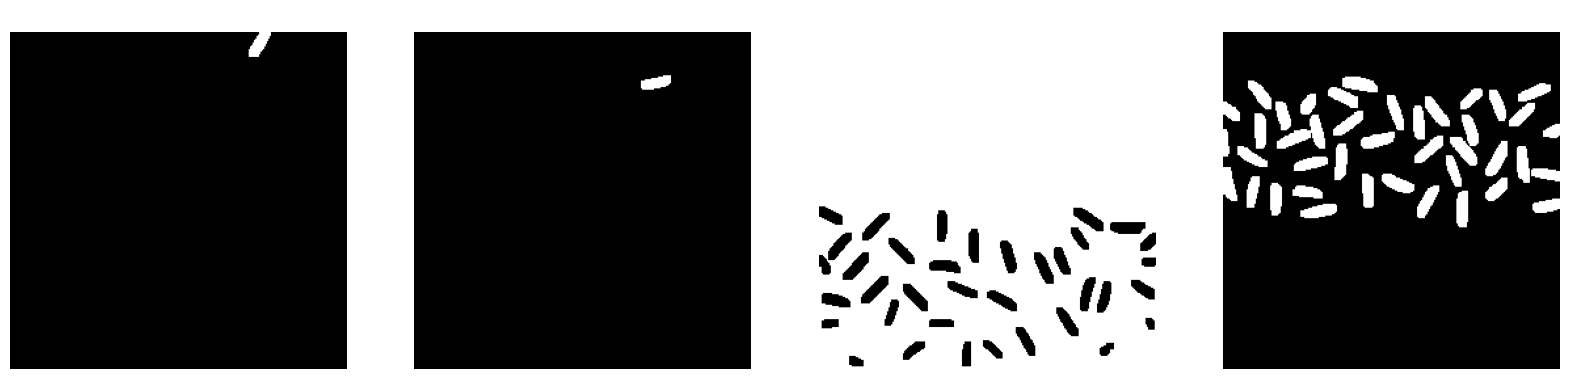

In [22]:
display_list([labels == 6, labels == 20, labels < 60, np.where((labels < 60) & (labels > 20),255,0)],4)

Labels might be show as a diffrences of colors

In [23]:
# color labels put on original image
color = sic.label2rgb(labels, image=img, bg_label=0)
color.shape
display_list([color], opencv = False)

## 3. Binary objects characteristics

In [24]:
# center of gravity (centroid) and smallest rectangle (bounding box)
img = cv2.imread('images/rice.tif',0)
_, binary = cv2.threshold(img,120,255,cv2.THRESH_BINARY)
elstr = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(binary,cv2.MORPH_OPEN,elstr)
labels = sime.label(opening)
charact = sime.regionprops(labels)
plt.figure(figsize=(6,6), dpi = 80)
plt.imshow(img, cmap=plt.cm.gray)

for obj in charact:
    y0, x0 = obj.centroid
    plt.plot(x0, y0, '.r', markersize=5)
    minr, minc, maxr, maxc = obj.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    plt.plot(bx, by, '-y', linewidth=1)
plt.show()

In [25]:
# histogram of sizes
sizes = np.zeros(len(charact))
for i in range(0,len(charact)):
    sizes[i] = charact[i]['area']
plt.hist(sizes,20)

(array([ 3.,  1.,  3.,  3.,  7.,  5.,  9., 15., 24., 14.,  2.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  4.,  1.]),
 array([ 15. ,  37.8,  60.6,  83.4, 106.2, 129. , 151.8, 174.6, 197.4,
        220.2, 243. , 265.8, 288.6, 311.4, 334.2, 357. , 379.8, 402.6,
        425.4, 448.2, 471. ]),
 <BarContainer object of 20 artists>)

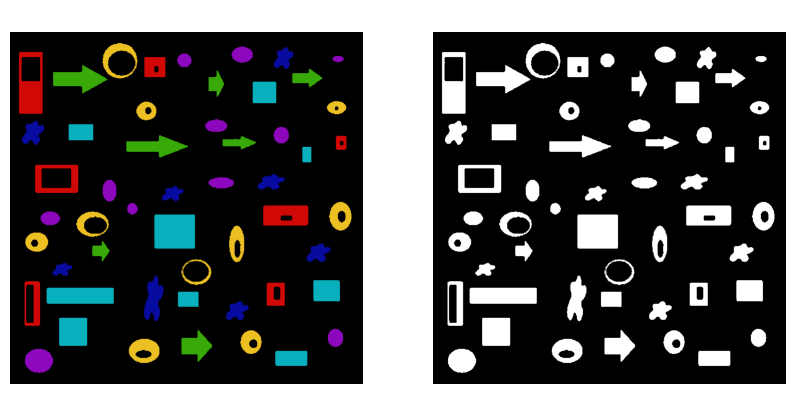

In [50]:
o = cv2.imread("images/obj.png")
b = o[:,:,1]>0
display_list([o,b],2)

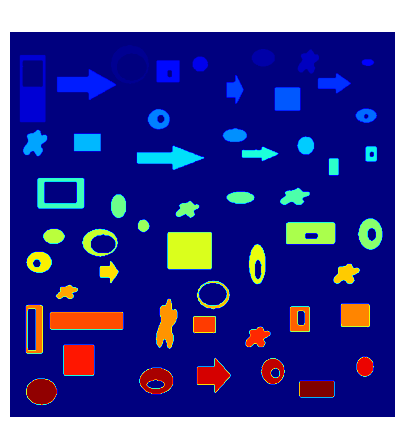

In [53]:
labels = sime.label(b)
display_list([labels],colmap = 'jet')

In [54]:
charact = sime.regionprops(labels)
plt.figure(figsize=(6,6), dpi = 80)
plt.imshow(labels, cmap=plt.cm.gray)
print(len(charact))
for obiekt in charact:
    y0, x0 = obiekt.centroid
    plt.plot(x0, y0, '.r', markersize=5)
    minr, minc, maxr, maxc = obiekt.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    plt.plot(bx, by, '-y', linewidth=1)

52


In [57]:
# characteristics extraction
# color search
colors = np.unique(o.reshape(-1, o.shape[2]), axis=0)
colors = colors[1:7,:] # delete color from background
print(colors)
      #   [[160,11,8], # dark blue
      #    [9,168,57], # green
      #    [6,9,209], # red
      #    [198,175,8], # blue
      #    [189,8,141], # violet
      #    [34,191,236]] # yellow
num_obj = len(charact)
num_cat = len(colors)
charact_list = ['EulerNumber','Area','BoundingBoxArea','FilledArea','Extent','EquivDiameter','Solidity']
charact_num = len(charact_list)
charact_table = np.zeros((num_obj,charact_num+1))
charact_table[0,:] = np.nan 
for i in range(0,num_obj):
    for j in range(0,charact_num):
      charact_table[i,j] = charact[i][charact_list[j]]
    x,y = charact[i]['Coordinates'][1] # wsp. jednego z punktów obiektu - do próbkowania koloru

    for k in range(0,num_cat):
        if list(o[x,y,:]) == list(colors[k,:]):
            break
    charact_table[i,-1] = k
charact_table[1:,0] = (charact_table[1:,0] == 1) # korekta liczby Eulera
print(charact_table[1,:])

[[  6   9 209]
 [  9 168  57]
 [ 34 191 236]
 [160  11   8]
 [189   8 141]
 [189 175   8]]
[  1.         136.         234.         136.           0.58119658
  13.15904928   0.91891892   5.        ]


In [73]:
charact_table[0:5,:] # first row

array([[  1.        ,  64.        ,  90.        ,  64.        ,
          0.71111111,   9.02703334,   0.92753623,   5.        ],
       [  1.        , 136.        , 234.        , 136.        ,
          0.58119658,  13.15904928,   0.91891892,   5.        ],
       [  1.        , 203.        , 275.        , 203.        ,
          0.73818182,  16.07692842,   0.93981481,   5.        ],
       [  1.        ,  21.        ,  24.        ,  21.        ,
          0.875     ,   5.17088295,   0.95454545,   5.        ],
       [  1.        , 126.        , 204.        , 126.        ,
          0.61764706,  12.66602474,   0.93333333,   5.        ]])

Selecting `charact_table` for specific objects selection.

In [60]:
# select objects belongs to las attr of class
# True - object belong, False - object doesnt belong
print(charact_table[:,-1]==2)
print(np.where(charact_table[:,-1]==2) + np.array(1))

[False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
[[23 25 26 65]]


In [62]:
# point to objects witch area less than 2000 pixels
charact_table[:,1] < 2000

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [66]:
# labels of this images
less_than_2000 = np.where(charact_table[:,1] < 2000) + np.array(1)
print(less_than_2000)

[[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
  49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
  73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]]


In [67]:
# is object 1 smaller than 2000 pix?
print(np.isin(1,less_than_2000))
# object 4
print(np.isin(4,less_than_2000))

True
True


Displaying images depending on characteristiccs list

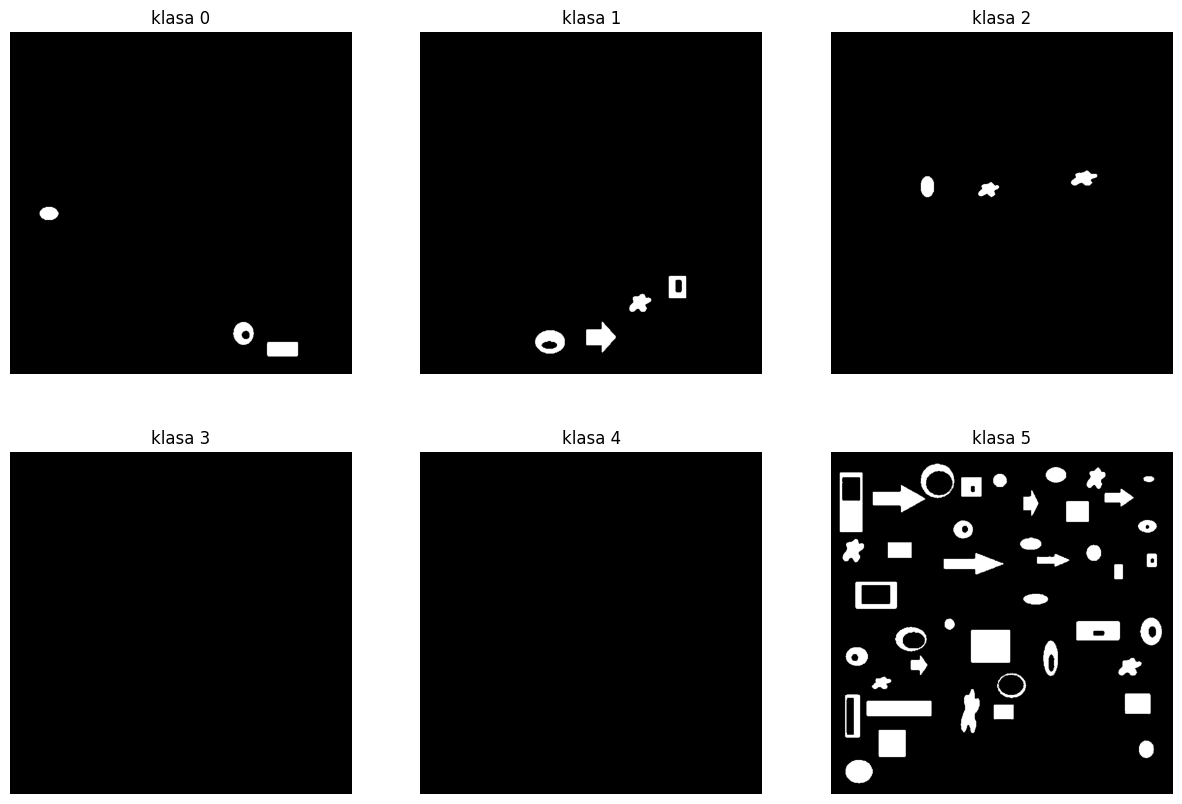

In [69]:
lio = []
lin = []
for class_num in range(6):
    lio.append(np.where(np.isin(labels,np.where(charact_table[:,-1] == class_num)+ np.array(1)),255,0))
    lin.append('Class ' + str(class_num))
display_list(lio,  3, lin, opencv = False)    

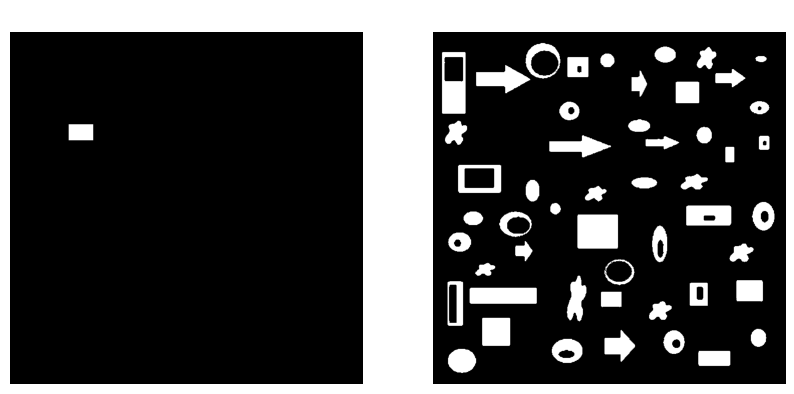

In [81]:
euler_0 = np.where(charact_table[:,0] == 0) + np.array(1)
euler_1 = np.where(charact_table[:,0] == 1) + np.array(1)
holes = [np.where(np.isin(labels,euler_0),255,0),np.where(np.isin(labels,euler_1),255,0)]
display_list(holes,2)

In [80]:
# attr 1 - area > 220
display_list([np.where(np.isin(labels,np.where(charact_table[:,1] > 220) + np.array(1)),255,0)])

Conversion numpy matrix to data frame with pandas

In [85]:
c = pd.DataFrame(columns = ["area","area without holes","Eulera","fill","radius", "fill with out holes","type"])
c["area"] = charact_table[:,1]
c["area with out holes"] = charact_table[:,2]
c["Eulera"] = charact_table[:,0]
c["fill"] = charact_table[:,4]
c["radius"] = charact_table[:,5]
c["fill without holes"] = charact_table[:,3]/charact_table[:,2]
c["type"] = charact_table[:,-1].astype(np.int16)
c = c.drop(0)
c.head()

area area without holes  Eulera  fill  radius fill with out holes  type  \
1 136.00                NaN    1.00  0.58   13.16                 NaN     5   
2 203.00                NaN    1.00  0.74   16.08                 NaN     5   
3  21.00                NaN    1.00  0.88    5.17                 NaN     5   
4 126.00                NaN    1.00  0.62   12.67                 NaN     5   
5 203.00                NaN    1.00  0.51   16.08                 NaN     5   

   area with out holes  fill without holes  
1               234.00                0.58  
2               275.00                0.74  
3                24.00                0.88  
4               204.00                0.62  
5               399.00                0.51

Graphical distinguishing classes of objects

In [89]:
sns.pairplot(c, kind="scatter", hue = "type", palette = 'tab10')

## 4. Features of binary objects with openCV

The `SimpleBlobDetector` function from the openCV package performs a simple task of detecting objects in the image whose values ​​of selected features are within the specified ranges.

In [93]:
img = cv2.imread("images/blob.jpg", 0)

par = cv2.SimpleBlobDetector_Params()
par.minThreshold = 10
par.maxThreshold = 250

par.filterByArea = True
par.minArea = 1500

par.filterByCircularity = True
par.minCircularity = 0.1

par.filterByConvexity = True
par.minConvexity = 0.87
    
par.filterByInertia = True
par.minInertiaRatio = 0.01

detector = cv2.SimpleBlobDetector_create(par)
objs = detector.detect(img)

draw = cv2.drawKeypoints(img, objs, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display_list([img, draw],2)